In [99]:
# Write your imports here
import re
import pandas as pd
import numpy as np
from tabulate import tabulate
from dateutil import parser
import matplotlib.pyplot as plt
import seaborn as sns

# Data Tidying and Cleaning Lab
## Reading, tidying and cleaning data. Preparing data for exploration, mining, analysis and learning

In this lab, you'll be working with the Coffee Quality Index dataset, located [here](https://www.kaggle.com/datasets/volpatto/coffee-quality-database-from-cqi). For convenience (and to save trouble in case you can't download files, or someone uploads a newer version), I've provided the dataset in the `data/` folder. The metadata (description) is at the Kaggle link. For this lab, you'll only need `merged_data_cleaned.csv`, as it is the concatenation of the other two datasets.

In this (and the following labs), you'll get several questions and problems. Do your analysis, describe it, use any tools and plots you wish, and answer. You can create any amount of cells you'd like.

Sometimes, the answers will not be unique, and they will depend on how you decide to approach and solve the problem. This is usual - we're doing science after all!

It's a good idea to save your clean dataset after all the work you've done to it.

### Problem 1. Read the dataset (1 point)
This should be self-explanatory. The first column is the index.

In [100]:
data_path = 'data/merged_data_cleaned.csv'

df = pd.read_csv(data_path)

### Problem 2. Observations and features (1 point)
How many observations are there? How many features? Which features are numerical, and which are categorical?

**Note:** Think about the _meaning_, not the data types. The dataset hasn't been thoroughly cleaned.

In [101]:
def get_colunmn_dtypes(df):
    numeric_cols = []
    categorical_cols = []
    for col in df.columns:
        if df[col].dtype == 'object':
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    return numeric_cols, categorical_cols

numeric_cols, categorical_cols = get_colunmn_dtypes(df)

def print_dataset_info(df, numeric_cols, categorical_cols):
    numeric_info = [
        [
            col,
            df[col].dtype,
            df[col].nunique(),
            df[col].isnull().sum(),
            f"{df[col].mean():.2f}",
            f"{df[col].std():.2f}",
            f"{df[col].min():.2f}",
            f"{df[col].max():.2f}"
        ] for col in numeric_cols
    ]
    
    categorical_info = [
        [
            col,
            df[col].dtype,
            df[col].nunique(),
            df[col].isnull().sum(),
            df[col].mode()[0] if not df[col].empty else 'N/A'
        ] for col in categorical_cols
    ]

    summary = f"""
Dataset Overview
==================
Shape: {df.shape[0]} rows × {df.shape[1]} columns

Numeric Features ({len(numeric_cols)}):
{tabulate(
    numeric_info,
    headers=['Feature', 'Type', 'Unique', 'Missing', 'Mean', 'Std', 'Min', 'Max'],
    tablefmt='grid',
    colalign=('left', 'left', 'right', 'right', 'right', 'right', 'right', 'right')
)}

Categorical Features ({len(categorical_cols)}):
{tabulate(
    categorical_info,
    headers=['Feature', 'Type', 'Unique', 'Missing', 'Mode'],
    tablefmt='grid',
    colalign=('left', 'left', 'right', 'right', 'left')
)}

Sample Data (First Row):
{tabulate(df.head(1), headers='keys', tablefmt='grid')}

Memory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB
"""
    print(summary)

print_dataset_info(df, numeric_cols, categorical_cols)


Dataset Overview
Shape: 1339 rows × 44 columns

Numeric Features (20):
+----------------------+---------+----------+-----------+---------+---------+-------+--------+
| Feature              | Type    |   Unique |   Missing |    Mean |     Std |   Min |    Max |
+======================+=========+==========+===========+=========+=========+=======+========+
| Unnamed: 0           | int64   |     1339 |         0 |     669 |  386.68 |     0 |   1338 |
+----------------------+---------+----------+-----------+---------+---------+-------+--------+
| Number.of.Bags       | int64   |      131 |         0 |  154.18 |  129.99 |     0 |   1062 |
+----------------------+---------+----------+-----------+---------+---------+-------+--------+
| Aroma                | float64 |       33 |         0 |    7.57 |    0.38 |     0 |   8.75 |
+----------------------+---------+----------+-----------+---------+---------+-------+--------+
| Flavor               | float64 |       35 |         0 |    7.52 |     0

### Problem 3. Column manipulation (1 point)
Make the column names more Pythonic (which helps with the quality and... aesthetics). Convert column names to `snake_case`, i.e. `species`, `country_of_origin`, `ico_number`, etc. Try to not do it manually.

In [102]:
def standardize_column_names(df):
    def to_snake_case(name):
        name = name.lower()
        name = re.sub(r'[^a-z0-9]', '_', name)
        name = re.sub(r'_+', '_', name)
        name = name.strip('_')
        return name
    
    df.columns = [to_snake_case(col) for col in df.columns]
    return df

df = standardize_column_names(df)

print("Standardized column names:")
print(df.columns.tolist())

Standardized column names:
['unnamed_0', 'species', 'owner', 'country_of_origin', 'farm_name', 'lot_number', 'mill', 'ico_number', 'company', 'altitude', 'region', 'producer', 'number_of_bags', 'bag_weight', 'in_country_partner', 'harvest_year', 'grading_date', 'owner_1', 'variety', 'processing_method', 'aroma', 'flavor', 'aftertaste', 'acidity', 'body', 'balance', 'uniformity', 'clean_cup', 'sweetness', 'cupper_points', 'total_cup_points', 'moisture', 'category_one_defects', 'quakers', 'color', 'category_two_defects', 'expiration', 'certification_body', 'certification_address', 'certification_contact', 'unit_of_measurement', 'altitude_low_meters', 'altitude_high_meters', 'altitude_mean_meters']


### Problem 4. Bag weight (1 point)
What's up with the bag weights? Make all necessary changes to the column values. Don't forget to document your methods and assumptions.

In [103]:
def normalize_weight(df):

    def convert_to_kg(weight_str):
        try:
            if pd.isna(weight_str) or not isinstance(weight_str, str):
                return None
                
            weight_str = weight_str.replace(',', ' ').strip().lower()
            parts = weight_str.split()
            
            if len(parts) == 1:
                return int(float(parts[0]))
            
            value = float(parts[0])
            unit = parts[1]
            
            if 'lbs' in unit:
                value = value * 0.45359237
                
            return int(round(value))
        except (ValueError, IndexError):
            return None

    df['bag_weight_original'] = df['bag_weight']
    
    df['bag_weight'] = df['bag_weight'].apply(convert_to_kg)
    
    print("Weight Normalization Summary:")
    print("-" * 30)
    print(f"Total rows: {len(df)}")
    print(f"Null values: {df['bag_weight'].isna().sum()}")
    print("\nSample of conversions:")
    print(df[['bag_weight_original', 'bag_weight']].head())
    
    return df

df = normalize_weight(df)

Weight Normalization Summary:
------------------------------
Total rows: 1339
Null values: 0

Sample of conversions:
  bag_weight_original  bag_weight
0               60 kg          60
1               60 kg          60
2                   1           1
3               60 kg          60
4               60 kg          60


### Problem 5. Dates (1 point)
This should remind you of problem 4 but it's slightly nastier. Fix the harvest years, document the process.

While you're here, fix the expiration dates, and grading dates. Unlike the other column, these should be dates (`pd.to_datetime()` is your friend).

In [104]:
print(f"harvest_year_uniq_values {df['harvest_year'].unique()} \n grading_date_uniq_values {df['grading_date'].unique()} \n expiration_uniq_values {df['expiration'].unique()}")

def parse_date_str(date_str):
    if pd.isna(date_str):
        return pd.NaT
    try:
        return parser.parse(date_str, fuzzy=True)
    except Exception:
        return pd.NaT
    
df['harvest_year_parsed'] = df['harvest_year'].apply(parse_date_str)
df['grading_date_parsed'] = df['grading_date'].apply(parse_date_str)
df['expiration_parsed'] = df['expiration'].apply(parse_date_str)

df['harvest_year_std'] = df['harvest_year_parsed'].dt.strftime('%Y-%m-%d')
df['grading_date_std'] = df['grading_date_parsed'].dt.strftime('%Y-%m-%d')
df['expiration_std'] = df['expiration_parsed'].dt.strftime('%Y-%m-%d')

print("Harvest Year (Original vs Standardized):")
print(df[['harvest_year', 'harvest_year_std']])
print("\nGrading Date (Original vs Standardized):")
print(df[['grading_date', 'grading_date_std']])
print("\nExpiration (Original vs Standardized):")
print(df[['expiration', 'expiration_std']])

df.drop(columns=[
    'harvest_year', 
    'grading_date', 
    'expiration', 
    'harvest_year_parsed', 
    'grading_date_parsed', 
    'expiration_parsed'
], inplace=True)

harvest_year_uniq_values ['2014' nan '2013' '2012' 'March 2010' 'Sept 2009 - April 2010'
 'May-August' '2009/2010' '2015' '2011' '2016' '2015/2016' '2010'
 'Fall 2009' '2017' '2009 / 2010' '2010-2011' '2009-2010' '2009 - 2010'
 '2013/2014' '2017 / 2018' 'mmm' 'TEST' 'December 2009-March 2010'
 '2014/2015' '2011/2012' 'January 2011' '4T/10' '2016 / 2017'
 '23 July 2010' 'January Through April' '1T/2011' '4t/2010' '4T/2010'
 'August to December' 'Mayo a Julio' '47/2010' 'Abril - Julio' '4t/2011'
 'Abril - Julio /2011' 'Spring 2011 in Colombia.' '3T/2011' '2016/2017'
 '1t/2011' '2018' '4T72010' '08/09 crop'] 
 grading_date_uniq_values ['April 4th, 2015' 'May 31st, 2010' 'March 26th, 2015'
 'September 3rd, 2013' 'September 17th, 2012' 'September 2nd, 2010'
 'March 30th, 2015' 'March 27th, 2015' 'March 13th, 2015'
 'August 31st, 2010' 'June 16th, 2010' 'April 7th, 2016'
 'March 25th, 2015' 'April 2nd, 2014' 'July 26th, 2012'
 'December 3rd, 2011' 'June 26th, 2014' 'May 18th, 2017' 'May 18th

### Problem 6. Countries (1 point)
How many coffees are there with unknown countries of origin? What can you do about them?

In [105]:
null_countries_df = df[df['country_of_origin'].isna()]

print("\n Missing Country of Origin Analysis")
print("=" * 50)
print(f"Total null entries: {len(null_countries_df)}")
print(f"Percentage of dataset: {(len(null_countries_df) / len(df)) * 100:.2f}%")

print("\nSample of rows with missing country:")
print("-" * 50)
display(null_countries_df.head(5))

print("\nValue distributions in rows with missing country:")
print("-" * 50)
for column in df.columns:
    if column != 'country_of_origin':
        print(f"\n{column}:")
        print(null_countries_df[column].value_counts().head(3))

df.dropna(subset=['country_of_origin'], inplace=True)
print(f"Rows after dropping missing countries: {len(df)}")


 Missing Country of Origin Analysis
Total null entries: 1
Percentage of dataset: 0.07%

Sample of rows with missing country:
--------------------------------------------------


,unnamed_0,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,certification_address,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters,bag_weight_original,harvest_year_std,grading_date_std,expiration_std
1197,1197,Arabica,racafe & cia s.c.a,NaN,NaN,NaN,NaN,3-37-1980,NaN,NaN,...,e493c36c2d076bf273064f7ac23ad562af257a25,70d3c0c26f89e00fdae6fb39ff54f0d2eb1c38ab,m,NaN,NaN,NaN,70 kg,NaN,2011-03-01,2012-02-29



Value distributions in rows with missing country:
--------------------------------------------------

unnamed_0:
unnamed_0
1197    1
Name: count, dtype: int64

species:
species
Arabica    1
Name: count, dtype: int64

owner:
owner
racafe & cia s.c.a    1
Name: count, dtype: int64

farm_name:
Series([], Name: count, dtype: int64)

lot_number:
Series([], Name: count, dtype: int64)

mill:
Series([], Name: count, dtype: int64)

ico_number:
ico_number
3-37-1980    1
Name: count, dtype: int64

company:
Series([], Name: count, dtype: int64)

altitude:
Series([], Name: count, dtype: int64)

region:
Series([], Name: count, dtype: int64)

producer:
Series([], Name: count, dtype: int64)

number_of_bags:
number_of_bags
149    1
Name: count, dtype: int64

bag_weight:
bag_weight
70    1
Name: count, dtype: int64

in_country_partner:
in_country_partner
Almacafé    1
Name: count, dtype: int64

owner_1:
owner_1
Racafe & Cia S.C.A    1
Name: count, dtype: int64

variety:
Series([], Name: count, dtype: i

### Problem 7. Owners (1 point)
There are two suspicious columns, named `Owner`, and `Owner.1` (they're likely called something different after you solved problem 3). Do something about them. Is there any link to `Producer`?

In [106]:
df['owner_match'] = df['owner'] == df['owner_1']
mismatched_owners = df[~df['owner_match']]

print("\n🔍 Owner Name Mismatches Analysis")
print("=" * 50)
print(f"Total mismatches: {len(mismatched_owners)}")
print("\nDetailed comparison:")
print("-" * 50)

comparison_df = mismatched_owners[['owner', 'owner_1']].copy()
comparison_df.columns = ['Owner (Original)', 'Owner_1 (Original)']
print(comparison_df.to_string(index=False))

mismatch_percentage = (len(mismatched_owners) / len(df)) * 100
print(f"\nMismatch percentage: {mismatch_percentage:.2f}%")

df.drop(columns=['owner_1', 'owner_match'], inplace=True)


🔍 Owner Name Mismatches Analysis
Total mismatches: 1335

Detailed comparison:
--------------------------------------------------
                                  Owner (Original)                                 Owner_1 (Original)
                          grounds for health admin                           Grounds for Health Admin
                               yidnekachew dabessa                                Yidnekachew Dabessa
                                         ji-ae ahn                                          Ji-Ae Ahn
                                     hugo valdivia                                      Hugo Valdivia
                       ethiopia commodity exchange                        Ethiopia Commodity Exchange
                       ethiopia commodity exchange                        Ethiopia Commodity Exchange
                            diamond enterprise plc                             Diamond Enterprise Plc
                                     mohammed lalo    

summary owner and owner_1 are same columns wich means we can remove ownwer column

### Problem 8. Coffee color by country and continent (1 point)
Create a table which shows how many coffees of each color are there in every country. Leave the missing values as they are.

**Note:** If you ask me, countries should be in rows, I prefer long tables much better than wide ones.

Now do the same for continents. You know what continent each country is located in.

In [107]:
country_to_continent = {
    'Ethiopia': 'Africa',
    'Guatemala': 'North America',
    'Brazil': 'South America',
    'Peru': 'South America',
    'United States': 'North America',
    'United States (Hawaii)': 'North America',
    'Indonesia': 'Asia',
    'China': 'Asia',
    'Costa Rica': 'North America',
    'Mexico': 'North America',
    'Uganda': 'Africa',
    'Honduras': 'North America',
    'Taiwan': 'Asia',
    'Nicaragua': 'North America',
    'Tanzania, United Republic Of': 'Africa',
    'Kenya': 'Africa',
    'Thailand': 'Asia',
    'Colombia': 'South America',
    'Panama': 'North America',
    'Papua New Guinea': 'Oceania',
    'El Salvador': 'North America',
    'Japan': 'Asia',
    'Ecuador': 'South America',
    'United States (Puerto Rico)': 'North America',
    'Haiti': 'North America',
    'Burundi': 'Africa',
    'Vietnam': 'Asia',
    'Philippines': 'Asia',
    'Rwanda': 'Africa',
    'Malawi': 'Africa',
    'Laos': 'Asia',
    'Zambia': 'Africa',
    'Myanmar': 'Asia',
    'Mauritius': 'Africa',
    'Cote d?Ivoire': 'Africa',
    'India': 'Asia'
}

df['continent'] = df['country_of_origin'].map(country_to_continent)

In [108]:
table_continent = (
    df.groupby(['continent', 'color'])
      .size()
      .reset_index(name='count')
)
print("Coffee color counts by continent:")
print(table_continent)

Coffee color counts by continent:
        continent         color  count
0          Africa    Blue-Green      6
1          Africa  Bluish-Green     22
2          Africa         Green    101
3            Asia    Blue-Green     24
4            Asia  Bluish-Green     20
5            Asia         Green    106
6   North America    Blue-Green     31
7   North America  Bluish-Green     48
8   North America         Green    447
9         Oceania  Bluish-Green      1
10  South America    Blue-Green     24
11  South America  Bluish-Green     23
12  South America         Green    216


### Problem 9. Ratings (1 point)
The columns `Aroma`, `Flavor`, etc., up to `Moisture` represent subjective ratings. Explore them. Show the means and range; draw histograms and / or boxplots as needed. You can even try correlations if you want. What's up with all those ratings?

Descriptive Statistics:
             aroma       flavor   aftertaste      acidity         body  \
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000   
mean      7.567317     7.521001     7.401816     7.536233     7.517451   
std       0.377040     0.398033     0.403723     0.379478     0.370198   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.420000     7.330000     7.250000     7.330000     7.330000   
50%       7.580000     7.580000     7.420000     7.580000     7.500000   
75%       7.750000     7.750000     7.580000     7.750000     7.670000   
max       8.750000     8.830000     8.670000     8.750000     8.580000   

           balance    sweetness   uniformity    clean_cup     moisture  
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000  
mean      7.518027     9.856584     9.834753     9.834985     0.088371  
std       0.409096     0.616320     0.554780     0.764218     0.048304  
min       0.00000

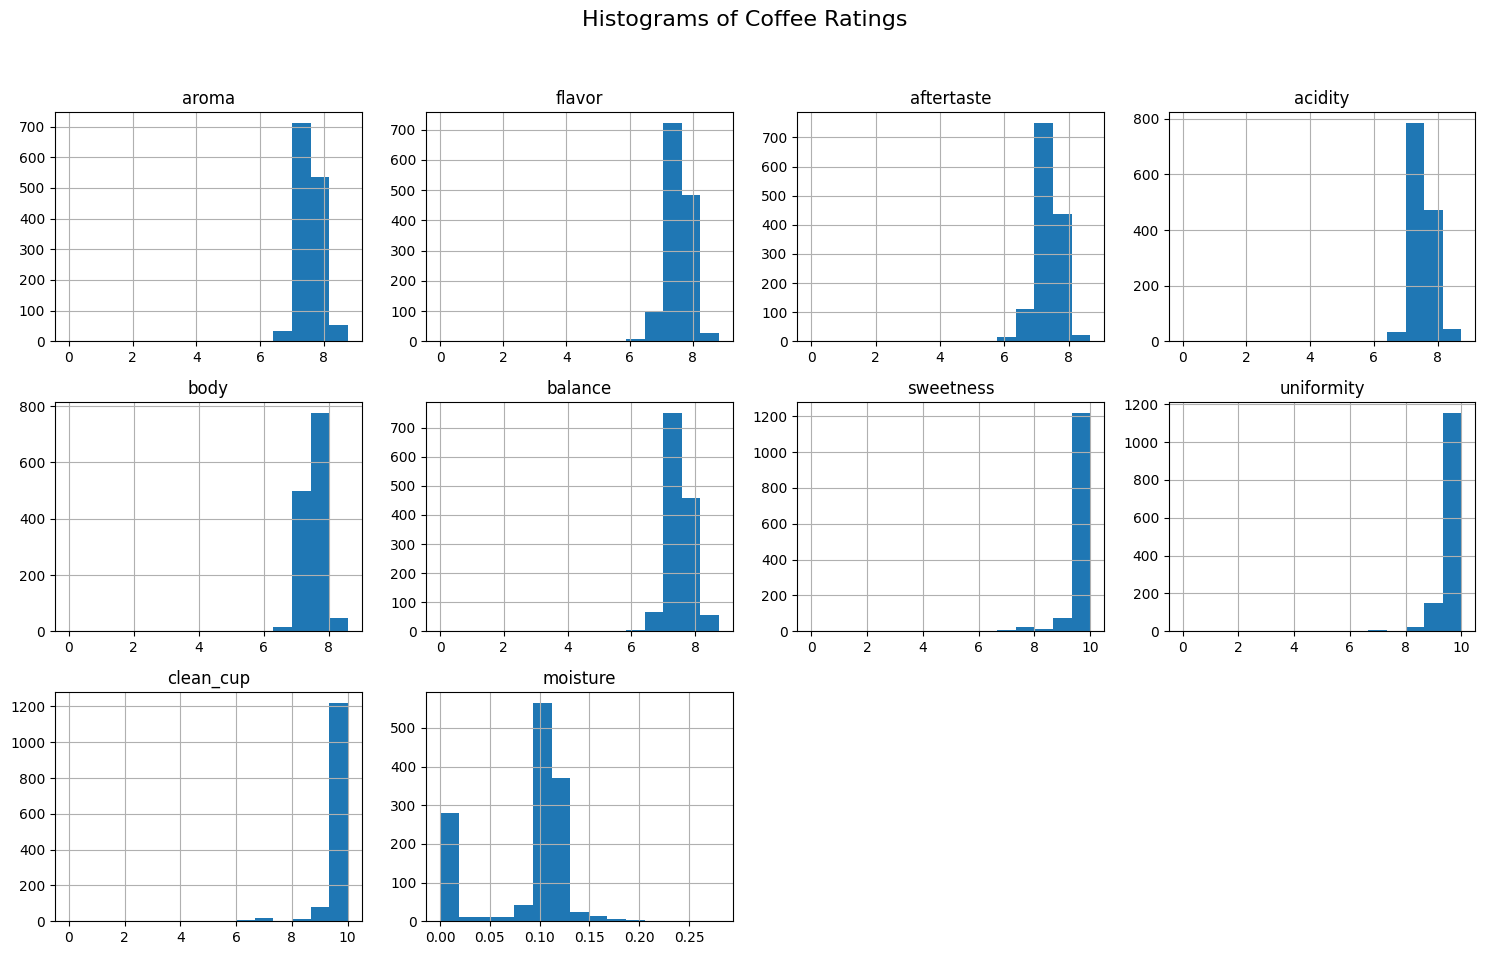

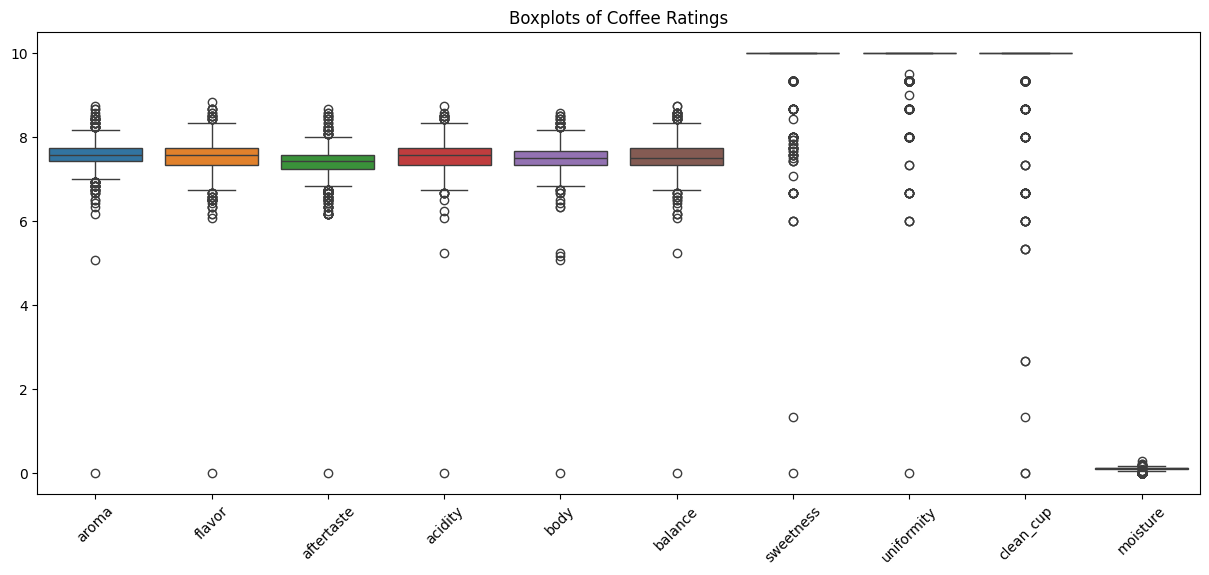

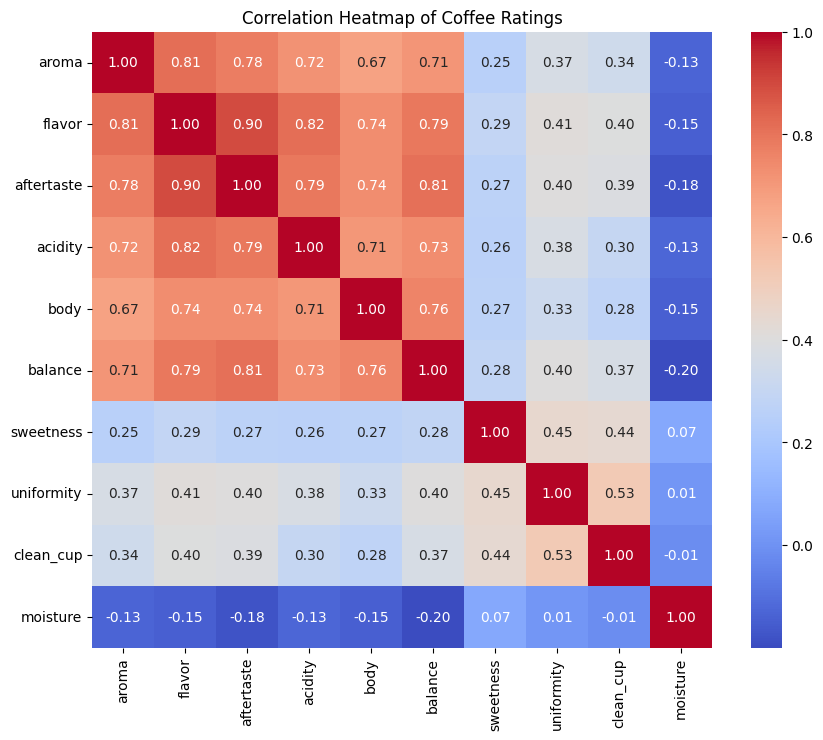

In [109]:
rating_columns = [
    'aroma', 'flavor', 'aftertaste', 'acidity',
    'body', 'balance', 'sweetness', 'uniformity',
    'clean_cup', 'moisture'
]


df[rating_columns] = df[rating_columns].apply(pd.to_numeric, errors='coerce')

desc = df[rating_columns].describe()
print("Descriptive Statistics:")
print(desc)

print("\nMeans and Ranges:")
for col in rating_columns:
    mean_val = df[col].mean()
    min_val = df[col].min()
    max_val = df[col].max()
    print(f"{col}: mean = {mean_val:.2f}, range = ({min_val}, {max_val})")

df[rating_columns].hist(bins=15, figsize=(15, 10), layout=(3, 4))
plt.suptitle("Histograms of Coffee Ratings", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(15, 6))
sns.boxplot(data=df[rating_columns])
plt.title("Boxplots of Coffee Ratings")
plt.xticks(rotation=45)
plt.show()

corr = df[rating_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Coffee Ratings")
plt.show()

### Problem 10. High-level errors (1 point)
Check the countries against region names, altitudes, and companies. Are there any discrepancies (e.g. human errors, like a region not matching the country)? Take a look at the (cleaned) altitudes; there has been a lot of preprocessing done to them. Was it done correctly?

In [110]:
regions_by_country = df.groupby('country_of_origin')['region'].unique()

print("Unique regions by country:")
for country, regions in regions_by_country.items():
    print(f"{country}: {regions}")

Unique regions by country:
Brazil: [nan 'south of minas' 'vale da grama' 'sul de minas - carmo de minas'
 'grama valley' 'mountains of minas gerais' 'mmm' 'test' 'cerrado'
 'minas gerais, br' 'carmo de minas' 'campos altos - cerrado' 'mogiana'
 'chapadão de ferro (cerrado mineiro)' 'high mogiana' 'sul de minas'
 'monte carmelo' 'brazil matas de minas' 'mantiqueira de minas'
 'matas de minas        ' 'alta paulista (sao paulo)'
 'cerrado - monte carmelo - minas gerais']
Burundi: ['kayanza' 'mumirwa']
China: ['yunnan' 'dehong prefecture' 'menglian' 'xishuangbanna prefecture']
Colombia: ['tolima' 'huila' 'santander' 'pasto' 'cundinamarca' 'cauca' 'pitalito'
 'la plata' 'nariño' 'huila supremo' 'guayata' 'eje cafetero' nan
 'antioquia' 'south huila'
 '52 narino (exact location: mattituy; municipal region: florida code 381'
 'pereira']
Costa Rica: ['san ramon' 'west and central valley' 'west valley' 'tarrazu'
 'costa rica' nan 'tres rios' 'valle central' 'central valley' 'turrialba'
 'occid

Altitude Summary Statistics:
count     1113
unique     396
top       1100
freq        43
Name: altitude, dtype: object


d:\MLC_TRAINING\DATA_SIENCE\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\MLC_TRAINING\DATA_SIENCE\env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23610 (\N{CJK UNIFIED IDEOGRAPH-5C3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


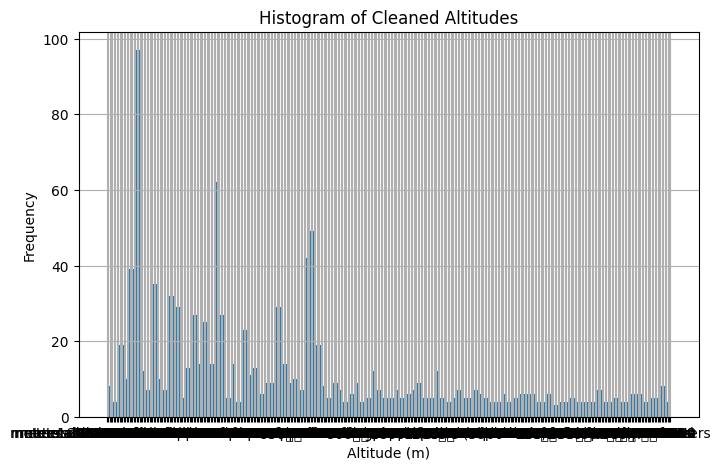

In [111]:
print("Altitude Summary Statistics:")
print(df['altitude'].describe())


plt.figure(figsize=(8, 5))
df['altitude'].dropna().hist(bins=100)
plt.xlabel("Altitude (m)")
plt.ylabel("Frequency")
plt.title("Histogram of Cleaned Altitudes")
plt.show()

In [112]:
companies_by_country = df.groupby('country_of_origin')['company'].unique()

print("Companies by country:")
for country, companies in companies_by_country.items():
    print(f"{country}: {companies}")

Companies by country:
Brazil: [nan 'nucoffee' 'cafebras comercio de cafés do brasil sa'
 'café do paraíso' 'ipanema coffees'
 'exportadora de cafés carmo de minas ltda' 'bourbon specialty coffees'
 'atlantica eportacao e importcao ltda' 'expocaccer' 'volcafe ltda.'
 'olam' 'klem organics coffee' 'cafe politico' 'garca armazens'
 'carmo coffees' 'green mountain coffee']
Burundi: ['the specialty coffee appraisers institute of asia'
 'sangana commodities k limited']
China: ['yunnan coffee exchange'
 'puer jiangcheng fuwang coffee biotechnology co., ltd'
 'yunnan new century tech inc.' 'yunnan louis herbs r& d center'
 'greenhouse coffee china']
Colombia: ['lusso coffee lab' 'exportadora de cafe condor s.a' 'ecom cca sa'
 'carcafe ltda' 'racafe & cia s.c.a' 'federacion nacional de cafeteros'
 'skn caribecafe ltda' 'olam international ltd' nan
 'olam specialty coffee' 'c.i.racafe & cia s.c.a' 'green mountain coffee'
 'essence coffee' 'coffeebythebag.com , inc.' 'coffee export'
 'the coffee 

### * Problem 11. Clean and explore at will
The dataset claimed to be clean, but we were able to discover a lot of things to fix and do better.

Play around with the data as much as you wish, and if you find variables to tidy up and clean - by all means, do that!

In [113]:
df

,unnamed_0,species,owner,country_of_origin,farm_name,lot_number,mill,ico_number,company,altitude,...,certification_contact,unit_of_measurement,altitude_low_meters,altitude_high_meters,altitude_mean_meters,bag_weight_original,harvest_year_std,grading_date_std,expiration_std,continent
0,0,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,60 kg,2014-02-10,2015-04-04,2016-04-03,Africa
1,1,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,60 kg,2014-02-10,2015-04-04,2016-04-03,Africa
2,2,Arabica,grounds for health admin,Guatemala,"san marcos barrancas ""san cristobal cuch",NaN,NaN,NaN,NaN,1600 - 1800 m,...,0878a7d4b9d35ddbf0fe2ce69a2062cceb45a660,m,1600.0,1800.0,1700.0,1,NaN,2010-05-31,2011-05-31,North America
3,3,Arabica,yidnekachew dabessa,Ethiopia,yidnekachew dabessa coffee plantation,NaN,wolensu,NaN,yidnekachew debessa coffee plantation,1800-2200,...,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1800.0,2200.0,2000.0,60 kg,2014-02-10,2015-03-26,2016-03-25,Africa
4,4,Arabica,metad plc,Ethiopia,metad plc,NaN,metad plc,2014/2015,metad agricultural developmet plc,1950-2200,...,19fef5a731de2db57d16da10287413f5f99bc2dd,m,1950.0,2200.0,2075.0,60 kg,2014-02-10,2015-04-04,2016-04-03,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,1334,Robusta,luis robles,Ecuador,robustasa,Lavado 1,our own lab,NaN,robustasa,NaN,...,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,NaN,NaN,NaN,2 kg,2016-02-10,2016-01-19,2017-01-18,South America
1335,1335,Robusta,luis robles,Ecuador,robustasa,Lavado 3,own laboratory,NaN,robustasa,40,...,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,40.0,40.0,40.0,2 kg,2016-02-10,2016-01-19,2017-01-18,South America
1336,1336,Robusta,james moore,United States,fazenda cazengo,NaN,cafe cazengo,NaN,global opportunity fund,795 meters,...,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,795.0,795.0,795.0,1 kg,2014-02-10,2014-12-23,2015-12-23,North America
1337,1337,Robusta,cafe politico,India,NaN,NaN,NaN,14-1118-2014-0087,cafe politico,NaN,...,352d0cf7f3e9be14dad7df644ad65efc27605ae2,m,NaN,NaN,NaN,5 lbs,2013-02-10,2014-08-25,2015-08-25,Asia
